In [1]:
import numpy as np
from itertools import count

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import gym
from nle import nethack

In [2]:
device = torch.device('cpu')
seed = 1
max_episode_steps = 2000
window = 25
gamma = 0.99
alpha = 0.1
render = False
max_char = 255 #nethack.OBSERVATION_DESC['chars']

In [3]:
ACTIONS = [
    nethack.CompassCardinalDirection.N,
    nethack.CompassCardinalDirection.E,
    nethack.CompassCardinalDirection.S,
    nethack.CompassCardinalDirection.W,
]

In [4]:
STATS_INDICES = {
    'x_coordinate': 0,
    'y_coordinate': 1,
    'score': 9,
    'health_points': 10,
    'health_points_max': 11,
    'hunger_level': 18,
}

In [5]:
env = gym.make("NetHackScore-v0", actions = ACTIONS)
env.seed(seed)
torch.manual_seed(seed)

In [6]:
#env.render() # How to see the environment
#env.step(action) # How to step through the environment 0 = UP, 1 = Right, 2 = Down, 3 = Left

In [7]:
class Policy(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(obs_size, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.affine2 = nn.Linear(256, 128)
#         self.dropout = nn.Dropout(p=0.5)
        self.affine3 = nn.Linear(128, 64)
#        self.dropout = nn.Dropout(p=0.4)
        self.affine4 = nn.Linear(64, act_size)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.affine2(x)
#         x = self.dropout(x)
        x = F.relu(x)
        x = self.affine3(x)
#         x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine4(x)
        return F.softmax(action_scores, dim=1)

In [8]:
def crop_glyphs(glyphs, x, y, size=7):
    x_max = 79
    y_max = 21

    x_start = x - size
    x_end = x + size

    if x_start < 0:
        x_end = x_end + (-1 * x_start)
        x_start = 0

    if x_end > x_max:
        x_start = x_start - (x_end - x_max)
        x_end = x_max

    y_start = y - size
    y_end = y + size

    if y_start < 0:
        y_end = y_end + (-1 * y_start)
        y_start = 0

    if y_end > y_max:
        y_start = y_start - (y_end - y_max)
        y_end = y_max

    y_range = np.arange(y_start, (y_end), 1)
    x_range = np.arange(x_start, (x_end), 1)
    window_glyphs = []
    for row in y_range:
        for col in x_range:
            window_glyphs.append(glyphs[row][col])

    crop = np.asarray(window_glyphs)

    return crop

In [9]:
def transform_observation(observation):
    """Process the state into the model input shape
    of ([glyphs, stats], )"""
#     observed_glyphs = observation['glyphs']

    stat_x_coord = observation['blstats'][STATS_INDICES['x_coordinate']]
    stat_y_coord = observation['blstats'][STATS_INDICES['y_coordinate']]
#     stat_health = float(observation['blstats'][STATS_INDICES['health_points']]) - float(
#         observation['blstats'][STATS_INDICES['health_points_max']] / 2)
#     stat_hunger = observation['blstats'][STATS_INDICES['hunger_level']]


    observed_chars = observation['chars']
    cropped_chars = crop_glyphs(observed_chars, stat_x_coord, stat_y_coord)
    # chars_mean = np.mean(cropped_chars)
    # chars_std = np.std(cropped_chars)
    # print('MEAN:', chars_mean)
    # print('STD:', chars_std)
    # norm_chars = (cropped_chars - chars_mean)/chars_std
#     chars_min = np.min(cropped_chars)
#     chars_max = np.max(cropped_chars)
#     chars_range = chars_max - chars_min
#     norm_chars = (cropped_chars - chars_min) / chars_range
    norm_chars = cropped_chars/max_char
    return norm_chars

In [10]:
#get observation size
#but change observation size to characters just around agent
state = transform_observation(env.reset())

In [11]:
policy = Policy(state.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()

In [12]:
def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

In [13]:
print(state)
print(type(state))
print(state.shape)

[0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.17647059
 0.17647059 0.17647059 0.17647059 0.17647059 0.17647059 0.1254902
 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.48627451 0.18039216 0.18039216 0.18039216 0.18039216
 0.48627451 0.1254902  0.1254902  0.1254902  0.1254902  0.1254902
 0.1254902  0.1254902  0.1254902  0.16862745 0.18039216 0.18039216
 0.4   

In [14]:
action = select_action(state)

In [15]:
action

2

In [16]:
episode_rewards = []
episode_loss = []

In [17]:
def finish_episode():
    R = 0
    policy_loss = []
    returns = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    episode_loss.append(policy_loss)
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]

In [18]:
def main():
    running_reward = 0
    for i_episode in range(1,300):
        state, ep_reward = transform_observation(env.reset()), 0
        for t in range(1, max_episode_steps):  # Don't infinite loop while learning
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            if render:
                env.render()
            state = transform_observation(state)
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break
        
        
        episode_rewards.append(ep_reward)
        running_reward = alpha * ep_reward + (1 - alpha) * running_reward
        finish_episode()

        if i_episode % window == 0:
            print('Episode {}\tLast reward: {:.2f}\tLast action: {}\tAverage reward: {:.2f}'.format(
                  i_episode, ep_reward, action, (sum(episode_rewards)/i_episode)))
#         if running_reward > 20:
#             print("Alert! Running reward is now {} and "
#                   "the last episode runs to {} time steps!".format(running_reward, t))
        if ((sum(episode_rewards)/i_episode) > 100) or ((sum(episode_rewards)/i_episode) < -25):
            print("End! Average reward is now {}".format((sum(episode_rewards)/i_episode)))
            break

In [19]:
main()

/home/clarise/anaconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Episode 25	Last reward: 4.72	Last action: 0	Average reward: 13.51
Episode 50	Last reward: 14.10	Last action: 3	Average reward: 17.67
Episode 75	Last reward: -9.76	Last action: 2	Average reward: 15.91
Episode 100	Last reward: 6.82	Last action: 0	Average reward: 17.00
Episode 125	Last reward: 43.77	Last action: 2	Average reward: 18.06
Episode 150	Last reward: -2.05	Last action: 3	Average reward: 18.56
Episode 175	Last reward: 123.97	Last action: 0	Average reward: 18.56
Episode 200	Last reward: 5.98	Last action: 2	Average reward: 19.45
Episode 225	Last reward: 12.45	Last action: 3	Average reward: 19.52
Episode 250	Last reward: -0.33	Last action: 0	Average reward: 19.04
Episode 275	Last reward: -6.74	Last action: 3	Average reward: 18.74


In [20]:
torch.save(policy, '/home/clarise/Desktop/COMS7053A - RL/mod_chars2.pt')

In [21]:
import matplotlib.pyplot as plt

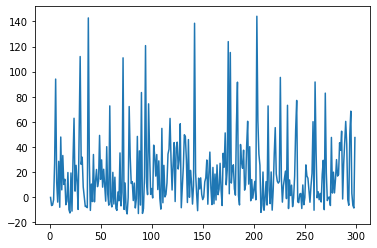

In [23]:
x = np.arange(1, len(episode_rewards)+1, 1)
y = episode_rewards
plt.plot(x,y)
plt.show()

In [24]:
avg = []
for i in range(x.shape[0]):
    rewards = sum(y[0:i])
    print(i, rewards)
    avg.append(rewards/x[i])
print(len(avg))

0 0
1 -0.3100000000000001
2 -7.089999999999815
3 -13.369999999999646
4 -15.519999999999554
5 11.58000000000053
6 105.65999999999698
7 117.62999999999712
8 113.60999999999721
9 142.09999999999664
10 133.95999999999677
11 181.82999999999777
12 187.56999999999795
13 220.69999999999848
14 230.7399999999986
15 244.92999999999873
16 238.79999999999885
17 235.49999999999895
18 255.06999999999874
19 245.08999999999892
20 232.39999999999915
21 251.60999999999825
22 240.39999999999844
23 270.0899999999979
24 332.9199999999977
25 337.63999999999777
26 362.93999999999744
27 374.86999999999756
28 364.9999999999977
29 413.12999999999903
30 525.1899999999978
31 551.289999999997
32 583.0899999999968
33 591.129999999997
34 591.0799999999971
35 583.5199999999973
36 576.1299999999974
37 567.6799999999976
38 710.5299999999945
39 738.5499999999931
40 727.8999999999933
41 738.2599999999934
42 734.6599999999935
43 768.5899999999936
44 764.7799999999936
45 777.0899999999938
46 799.0799999999927
47 807.3699999

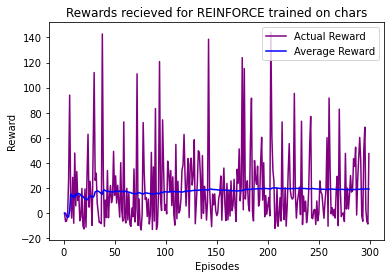

In [25]:
x = np.arange(1, len(episode_rewards)+1, 1)
y = episode_rewards
plt.plot(x,y, color = 'Purple', label = 'Actual Reward')
plt.plot(x, avg, color = 'Blue', label = 'Average Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards recieved for REINFORCE trained on chars')
plt.legend()
plt.show()